In [2]:
from google.colab import files
uploaded = files.upload()


Saving dataset.csv to dataset.csv


In [3]:
import pandas as pd

df = pd.read_csv("dataset.csv")

df.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


## Model 1: Basic Occupancy-Based Pricing

This is a simple model where price increases linearly as more vehicles are parked.

**Formula:**  
`Price = Base + α × (Occupancy / Capacity)`

This acts as a baseline to compare with smarter pricing models.


In [4]:
def basic_pricing_model(occupancy, capacity, base_price=10, alpha=2):
    """
    Model 1: Simple pricing based on occupancy rate.
    """
    if capacity == 0:
        return base_price  # To avoid division by zero
    occupancy_rate = occupancy / capacity
    new_price = base_price + alpha * occupancy_rate
    return round(new_price, 2)


In [5]:
# Pick the first row of the dataset
sample = df.iloc[0]

# Get occupancy and capacity
occupancy = sample['Occupancy']
capacity = sample['Capacity']

# Use your model to calculate price
price = basic_pricing_model(occupancy, capacity)

print("Parking price based on current occupancy:", price)


Parking price based on current occupancy: 10.21


In [6]:
# Apply model to every row and create a new 'Price' column
df['Predicted_Price'] = df.apply(
    lambda row: basic_pricing_model(row['Occupancy'], row['Capacity']),
    axis=1
)

# Show the updated dataframe
df[['Occupancy', 'Capacity', 'Predicted_Price']].head()


,Occupancy,Capacity,Predicted_Price
0,61,577,10.21
1,64,577,10.22
2,80,577,10.28
3,107,577,10.37
4,150,577,10.52


In [7]:
# Set up weights for each feature
vehicle_type_weights = {
    'car': 1.0,
    'bike': 0.5,
    'truck': 1.5
}


## Model 2: Demand-Based Dynamic Pricing

This model uses real-world features like:
- Traffic Condition
- Queue Length
- Vehicle Type
- Special Day

Each feature affects demand. The higher the demand, the more the price increases.

**Formula:**  
`Price = Base × (1 + λ × Normalized Demand)`


In [10]:
def demand_based_pricing(row, base_price=10, lambda_factor=0.2):
    """
    Model 2: Dynamic price based on demand features
    """
    capacity = row['Capacity']
    occupancy = row['Occupancy']
    queue = row['QueueLength']
    traffic = row['TrafficConditionNearby']
    special = row['IsSpecialDay']
    vehicle = row['VehicleType']

    # Convert traffic to numeric (if it's string)
    traffic_level = {'low': 1, 'medium': 2, 'high': 3}
    traffic_val = traffic_level.get(str(traffic).lower(), 2)

    # Get vehicle weight
    vehicle_weight = vehicle_type_weights.get(str(vehicle).lower(), 1.0)

    # Avoid division by zero
    if capacity == 0:
        return base_price

    # Step 1: Compute demand score
    occupancy_rate = occupancy / capacity
    demand = (occupancy_rate + 0.3 * queue - 0.2 * traffic_val +
              0.5 * special + 0.5 * vehicle_weight)

    # Step 2: Normalize demand to range 0–1
    norm_demand = min(max(demand / 5, 0), 1)

    # Step 3: Final price
    price = base_price * (1 + lambda_factor * norm_demand)

    return round(price, 2)


In [11]:
df['Demand_Based_Price'] = df.apply(demand_based_pricing, axis=1)
df[['Occupancy', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Demand_Based_Price']].head()


,Occupancy,QueueLength,TrafficConditionNearby,IsSpecialDay,VehicleType,Demand_Based_Price
0,61,1,low,0,car,10.28
1,64,1,low,0,car,10.28
2,80,2,low,0,car,10.42
3,107,2,low,0,car,10.43
4,150,2,low,0,bike,10.36


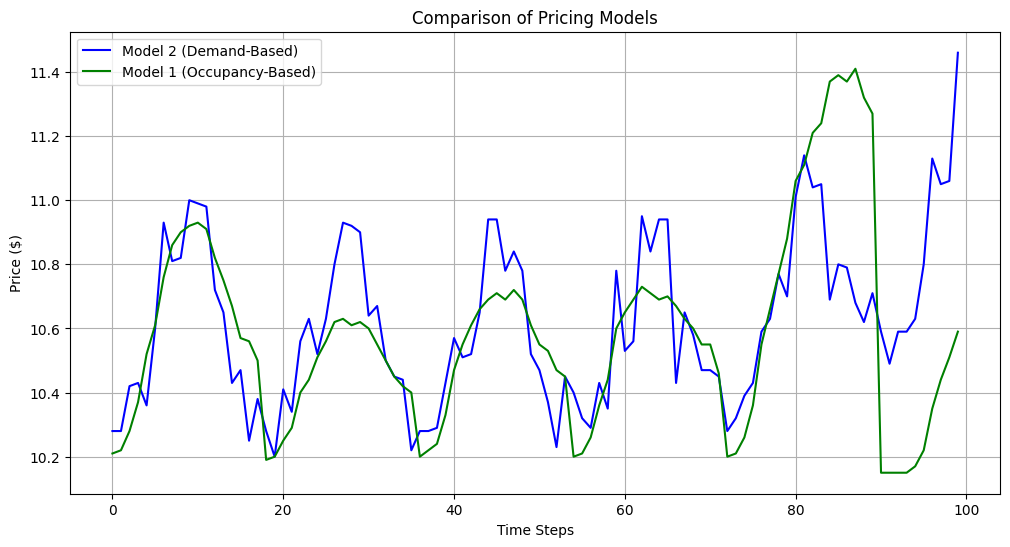

In [12]:
import matplotlib.pyplot as plt

# Create a sample range of 100 rows to keep it simple
sample_df = df.head(100)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(sample_df['Demand_Based_Price'], label='Model 2 (Demand-Based)', color='blue')
plt.plot(sample_df['Predicted_Price'], label='Model 1 (Occupancy-Based)', color='green')
plt.title('Comparison of Pricing Models')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()
